In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from mpl_toolkits.mplot3d import Axes3D

In [3]:
train = pd.read_csv("./input/Train/train.csv")
test = pd.read_csv("./input/Test/test.csv")

print("shape of train: ", train.shape, "shape of test: ", test.shape)

shape of train:  (7767, 563) shape of test:  (3162, 563)


In [4]:
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


Observation: Train data and test data is divided in approximately 70:30. There are no missing values.

### Visualizations for Train data

In [5]:
print(train.Activity.value_counts())

STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Activity, dtype: int64


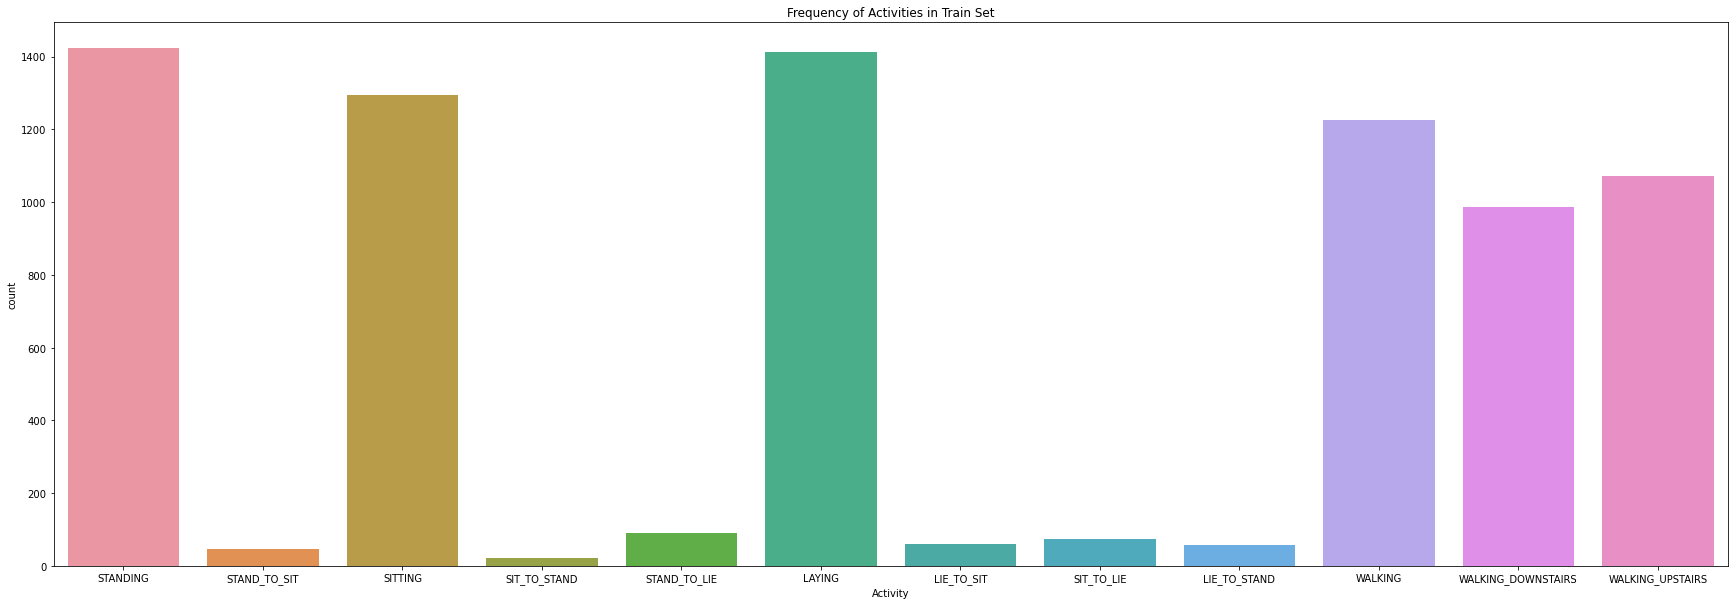

In [6]:
plt.figure(figsize = (30,10))
sns.countplot(x=train.Activity)
plt.xlabel('Activity')
plt.ylabel('count')
plt.title('Frequency of Activities in Train Set')
plt.show()

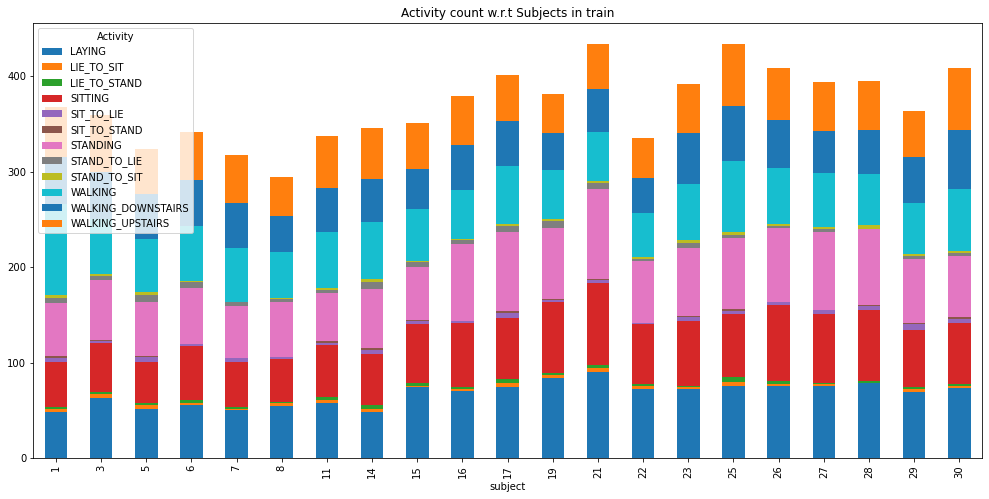

In [7]:
# Stacked Bar Chart for different activities with regards to subjects

stack_group = train.groupby(['subject', 'Activity']).size().unstack()
stack_group.plot(kind='bar', stacked=True, figsize=(17, 8), title = 'Activity count w.r.t Subjects in train')
plt.show()

### Visualizations for Test data

In [8]:
print(test.Activity.value_counts())

STANDING              556
LAYING                545
SITTING               508
WALKING               496
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
STAND_TO_LIE           49
SIT_TO_LIE             32
LIE_TO_STAND           27
LIE_TO_SIT             25
STAND_TO_SIT           23
SIT_TO_STAND           10
Name: Activity, dtype: int64


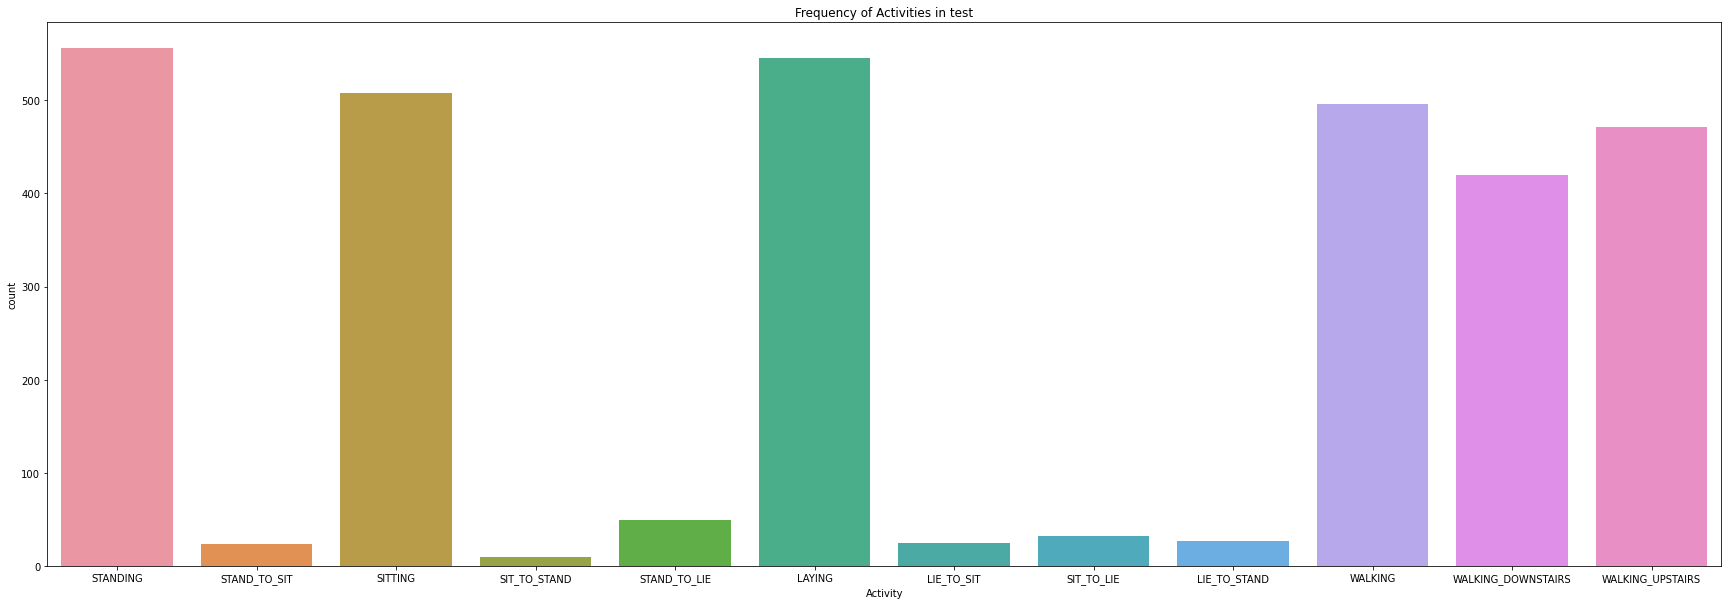

In [9]:
plt.figure(figsize = (30,10))
sns.countplot(x=test.Activity)
plt.xlabel('Activity')
plt.ylabel('count')
plt.title('Frequency of Activities in test')
plt.show()

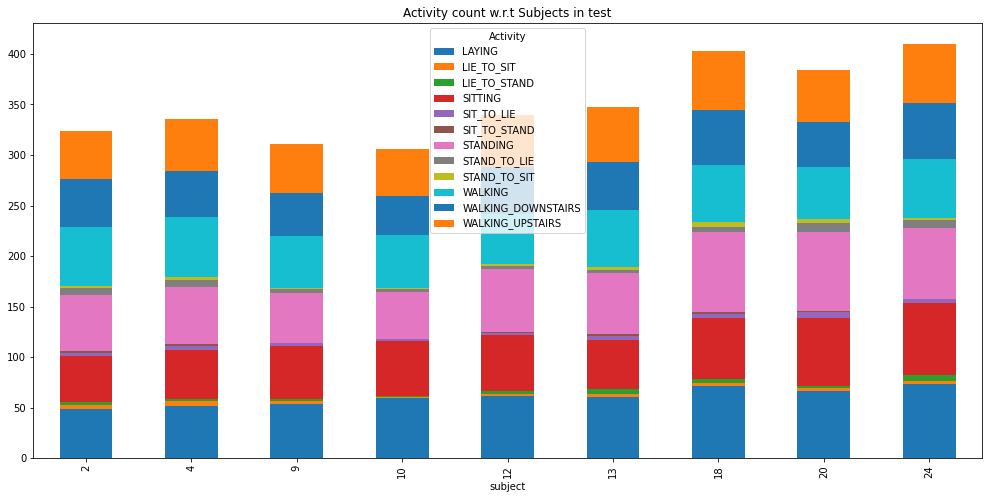

In [74]:
# Stacked Bar Chart for different activities with regards to subjects

stack_group = test.groupby(['subject', 'Activity']).size().unstack()
stack_group.plot(kind='bar', stacked=True, figsize=(17, 8), title = 'Activity count w.r.t Subjects in test')
plt.show()

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [113]:
# First, we need to standardize the data to get better performance
features = train.columns.values.tolist()
features.remove('Activity')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

targets = train['Activity'].unique()

train_labels = pd.DataFrame(train_labels, columns=['Activity'])
validation_labels = pd.DataFrame(validation_labels, columns=['Activity'])

### Principal Component Analysis (PCA)
We want to use PCA to reduce the the multidimension features in our data into fewer dimensions to better understand the data distribution. We are interested to find out whether the classes are separable using these selected principal components.

#### 2 Components PCA

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(train_features)
principalDf = pd.DataFrame(data = X_train
             , columns = ['PC1', 'PC2'])

In [125]:
finalDf = pd.concat([principalDf, train_labels], axis = 1)

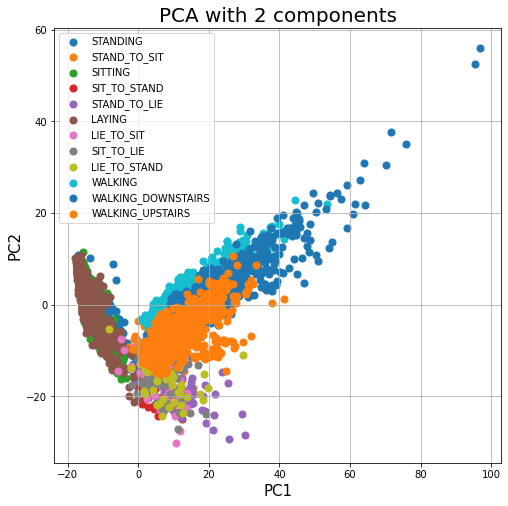

In [121]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA with 2 components', fontsize = 20)

for target in targets:
    indicesToKeep = finalDf['Activity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 50)
ax.legend(targets)
ax.grid()

In [124]:
pca.explained_variance_ratio_

array([0.48084453, 0.08118865])

From the result above we can see that the first principal component contains 48.08% of the variance and the second principal component contains 8.11% of the variance. Together, the two components contain 56.19% of the information, which is not very representative. The classes are also overlapping.

#### 3 Components PCA

In [26]:
pca3 = PCA(n_components=3)
PC3 = pca3.fit_transform(x)
principalDf3 = pd.DataFrame(data = PC3
             , columns = ['PC1', 'PC2', 'PC3'])

In [27]:
finalDf3 = pd.concat([principalDf3, train[['Activity']]], axis = 1)

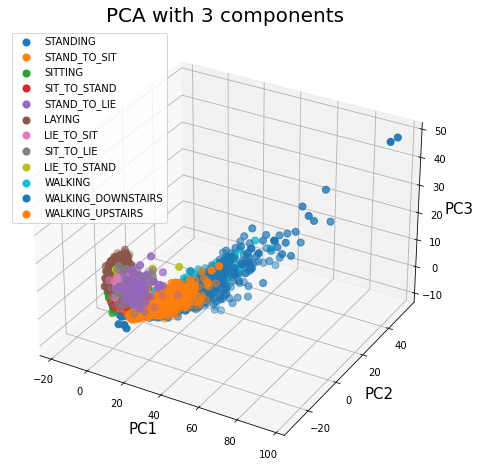

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('PCA with 3 components', fontsize = 20)
targets = train['Activity'].unique()

for target in targets:
    indicesToKeep = finalDf3['Activity'] == target
    ax.scatter(finalDf3.loc[indicesToKeep, 'PC1']
               , finalDf3.loc[indicesToKeep, 'PC2']
               , finalDf3.loc[indicesToKeep, 'PC3']
               , s = 50)
ax.legend(targets)
ax.grid()

In [30]:
PC3.shape

(7767, 3)

In [31]:
pca3.explained_variance_ratio_

array([0.4814824 , 0.0808861 , 0.03190478])

From the variance ratio above we can see that the first principal component contains 48.15% of the variance and the second principal component contains 8.08% of the variance, and the third principal component contains 3.19% of the variance. Together, the three components contain 59.42% of the information, which is still considerably small. The classes are again overlapping.

In [70]:
pca_n = PCA(n_components=120)
PCN = pca_n.fit_transform(x)

In [71]:
PCN.shape

(7767, 120)

In [72]:
np.sum(pca_n.explained_variance_ratio_)

0.9628601905951213

### Isomap Embedding

In [32]:
# First, we need to standardize the data to get better performance
from sklearn.preprocessing import StandardScaler
features = train.columns.values.tolist()
features.remove('Activity')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [33]:
from sklearn.manifold import Isomap as ISO

iso = ISO(n_components = 2)
isomap = iso.fit_transform(x)
isomapTempDf = pd.DataFrame(data = isomap, columns = ["ISO1", "ISO2"])

In [34]:
isomapFinalDf = pd.concat([isomapTempDf, train[['Activity']]], axis = 1)

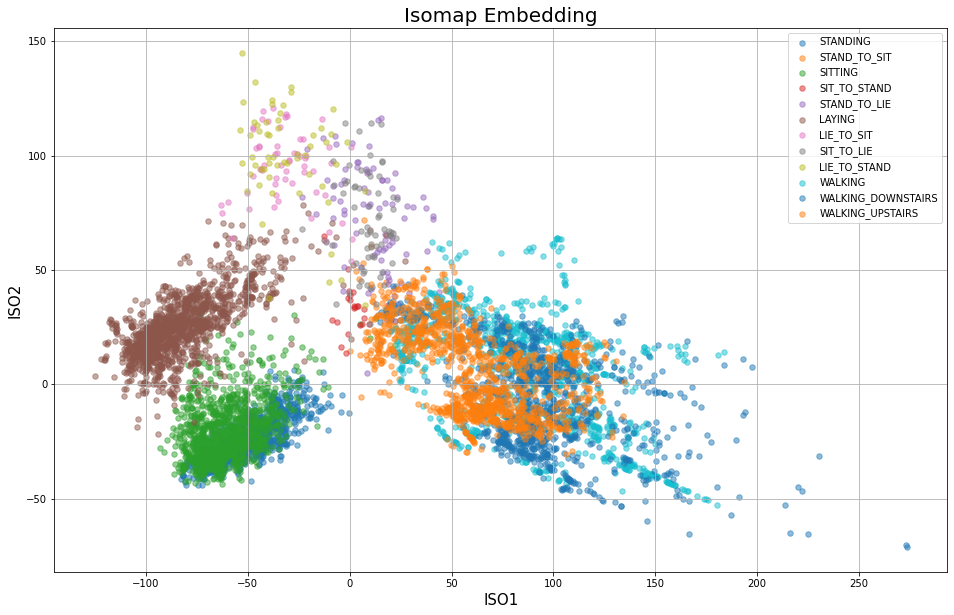

In [36]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ISO1', fontsize = 15)
ax.set_ylabel('ISO2', fontsize = 15)
ax.set_title('Isomap Embedding', fontsize = 20)
targets = train['Activity'].unique()

for target in targets:
    indicesToKeep = isomapFinalDf['Activity'] == target
    ax.scatter(isomapFinalDf.loc[indicesToKeep, 'ISO1']
               , isomapFinalDf.loc[indicesToKeep, 'ISO2']
               , s = 30
               , alpha = 0.5)
ax.legend(targets)
ax.grid()

In [37]:
isomap.shape

(7767, 2)

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

In [155]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 50, n_iter = 2500)
tsne_results = tsne.fit_transform(train_features)

df_subset = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two', 'Activities'])
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]
df_subset['Activities'] = train_labels

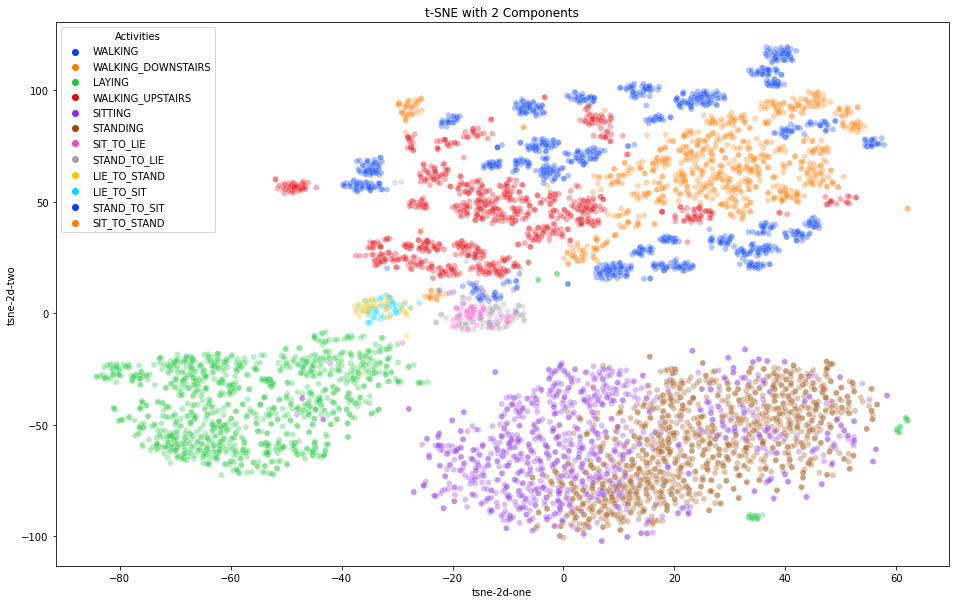

In [156]:
plt.figure(figsize = (16, 10))
plt.title('t-SNE with 2 Components')

sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = "Activities",
    palette = "bright",
    data = df_subset,
    legend = "full",
    alpha = 0.3
)

plt.show()

In [126]:
tsne_results.shape

(7767, 3)

In [163]:
pca = PCA(n_components=120, random_state = 1300)  
X_train = pca.fit_transform(train_features)  
X_val = pca.transform(validation_features) 

In [132]:
from sklearn.tree import DecisionTreeClassifier

In [133]:
dt = DecisionTreeClassifier()
dt.fit(X_train, train_labels)

DecisionTreeClassifier()

In [164]:
dt.score(X_val, validation_labels)

0.8187435633367662

In [135]:
dt.score(X_train, train_labels)

1.0

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
# Based on number of trees
clf_RF_n = [RandomForestClassifier(n_estimators = 50, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, random_state  = 1300),
            RandomForestClassifier(n_estimators = 400, random_state  = 1300),
            RandomForestClassifier(n_estimators = 500, random_state  = 1300)]

In [145]:
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer

acc_RF_n = []
ex_time_RF_n = []

for clf in clf_RF_n:
    start_time = timer()
    fit = clf.fit(X_train, np.ravel(train_labels))
    pred = fit.predict(X_val)
    accuracy = accuracy_score(validation_labels, pred)
    elapsed = timer() - start_time
    
    ex_time_RF_n.append(elapsed)
    acc_RF_n.append(accuracy)

In [146]:
acc_RF_n

[0.9145211122554068,
 0.9294541709577755,
 0.931513903192585,
 0.9289392378990731,
 0.9284243048403708]

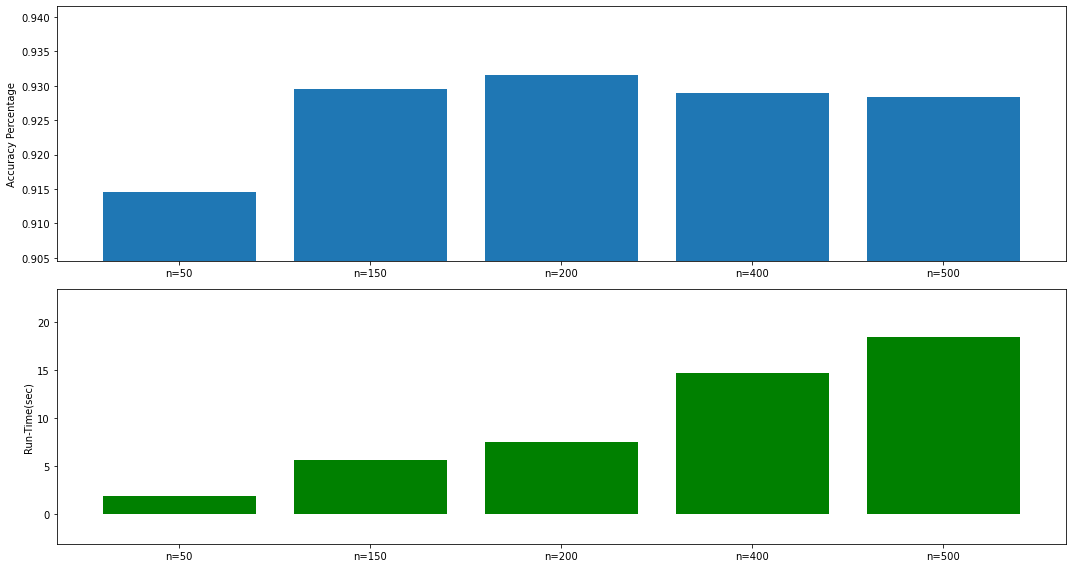

In [147]:
# Graphical Representation of ACCURACY and EXECUTION Time for RANDOM FOREST CLASSIFIER

label = ('n=50','n=150','n=200','n=400','n=500')
Accu = acc_RF_n
ExTime = ex_time_RF_n

plt.figure(figsize = (15,8))
y_pos = np.arange(len(label))

#Accuracy
plt.subplot(2,1,1)
plt.bar(y_pos, Accu, align='center')
plt.xticks(y_pos, label)
plt.ylim(min(Accu)- 0.01 , max(Accu) +0.01)
plt.ylabel('Accuracy Percentage')

#Execution Time
plt.subplot(2,1,2)
plt.bar(y_pos, ExTime, align='center', color = 'g')
plt.xticks(y_pos, label)
plt.ylim(min(ExTime)- 5 , max(ExTime) +5)
plt.ylabel('Run-Time(sec)')

plt.tight_layout()
plt.show()

In [160]:
clf_RF_d = [RandomForestClassifier(n_estimators = 200, max_depth = 10, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, max_depth = 20, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, max_depth = 40, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, max_depth = 50,random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, max_depth = 70, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, max_depth = 200, random_state  = 1300)]

In [161]:
ex_time_RF_d = []
acc_RF_d = []

for clf in clf_RF_d :
    start_time = timer()
    fit = clf.fit(X_train, np.ravel(train_labels))
    pred = fit.predict(X_test)
    accuracy = accuracy_score(validation_labels, pred)
    elapsed = timer() - start_time
    
    ex_time_RF_d.append(elapsed)
    acc_RF_d.append(accuracy)

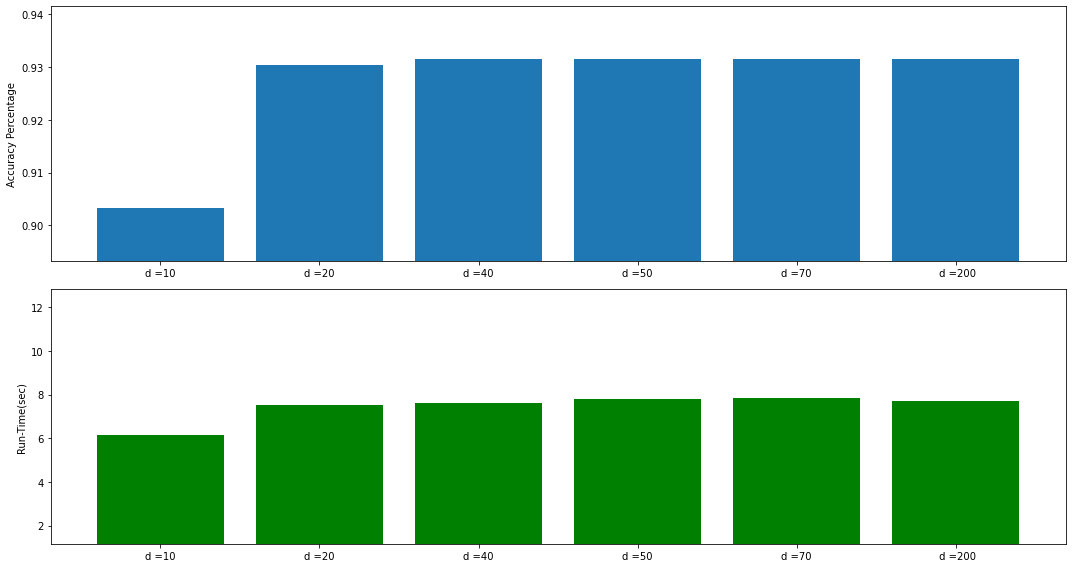

In [162]:
# Graphical Representation of ACCURACY and Execution Time for Random Forest with n = 200 and different max depths of a tree.

label = ('d =10','d =20','d =40','d =50','d =70', ' d =200')
Accu = acc_RF_d
ExTime = ex_time_RF_d


plt.figure(figsize = (15,8))
y_pos = np.arange(len(label))

#Accuracy
plt.subplot(2,1,1)
plt.bar(y_pos, Accu, align='center')
plt.xticks(y_pos, label)
plt.ylim(min(Accu)- 0.01 , max(Accu) +0.01)
plt.ylabel('Accuracy Percentage')

#Execution Time
plt.subplot(2,1,2)
plt.bar(y_pos, ExTime, align='center', color = 'g')
plt.xticks(y_pos, label)
plt.ylim(min(ExTime)- 5 , max(ExTime) +5)
plt.ylabel('Run-Time(sec)')

plt.tight_layout()
plt.show()

# Factor Analysis

We want to use Factor Analysis to find latent variables which can help us have a clearer interpretation of the variables and model.

In [4]:
# Loading the data and preprocessing the data
# Dropping columns that are unnecessary or are non float.
fa_train = train.copy()
fa_train = fa_train.sort_values("Activity")
fa_train.drop(['subject', 'Activity'], axis = 1, inplace = True)
result = fa_train.columns

In [5]:
fa_train.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
5873,0.035418,-0.003496,-0.019197,-0.992451,-0.996592,-0.993081,-0.992709,-0.996058,-0.993313,-0.799618,...,0.384303,-0.447457,-0.791666,0.003780,0.010927,-0.522986,0.542506,0.701667,-0.502293,-0.486076
3535,0.033435,0.013202,-0.026554,-0.992647,-0.955888,-0.979973,-0.992478,-0.952421,-0.981111,-0.799591,...,0.250039,-0.123744,-0.421313,-0.083411,0.042263,-0.056860,-0.118834,0.406107,-0.329966,-0.648314
3534,0.036000,0.022551,-0.035468,-0.992514,-0.971674,-0.988887,-0.992230,-0.971522,-0.989609,-0.800324,...,0.357742,-0.558631,-0.793670,-0.011265,-0.332927,0.113540,-0.144261,0.403848,-0.317029,-0.660747
3533,0.039373,-0.002382,-0.023495,-0.996246,-0.967241,-0.981788,-0.996713,-0.966373,-0.984032,-0.800324,...,0.543957,-0.139069,-0.370258,0.533790,-0.051320,0.071092,0.112552,0.404054,-0.314696,-0.663149
3532,0.041752,-0.023003,-0.006169,-0.993298,-0.987312,-0.988642,-0.993585,-0.987625,-0.989264,-0.793177,...,0.341884,-0.325342,-0.635577,0.021184,0.023187,-0.323193,0.215663,0.405600,-0.324542,-0.653650


In [6]:
# Scale the data accordingly
scaler = StandardScaler()

scaled_fa = fa_train.copy()
scaled_fa = pd.DataFrame(scaler.fit_transform(scaled_fa), columns = scaled_fa.columns)

In [7]:
scaled_fa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7767 entries, 0 to 7766
Columns: 561 entries, tBodyAcc-Mean-1                 to tZAxisAcc-AngleWRTGravity-1    
dtypes: float64(561)
memory usage: 33.2 MB


In [8]:
scaled_fa.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
0,-0.032757,-0.028506,-0.011595,-0.891227,-0.985398,-0.938409,-0.882169,-0.971813,-0.928679,-0.880198,...,0.937856,-0.417068,-0.550414,-0.039220,-0.017009,-0.885317,1.147747,2.332084,-1.836828,-1.568513
1,-0.052199,0.138530,-0.093408,-0.891671,-0.874649,-0.897652,-0.881617,-0.846412,-0.883914,-0.880144,...,0.372070,0.614263,0.673647,-0.302396,0.053646,-0.109951,-0.238166,1.751695,-1.264019,-2.155951
2,-0.027051,0.232056,-0.192543,-0.891370,-0.917600,-0.925368,-0.881022,-0.901303,-0.915090,-0.881612,...,0.825930,-0.771261,-0.557035,-0.084631,-0.792310,0.173496,-0.291451,1.747260,-1.221019,-2.200972
3,0.006019,-0.017364,-0.059391,-0.899823,-0.905540,-0.903295,-0.891744,-0.886507,-0.894630,-0.881612,...,1.610641,0.565437,0.842390,1.560544,-0.157359,0.102888,0.246730,1.747665,-1.213264,-2.209667
4,0.029351,-0.223633,0.133289,-0.893146,-0.960148,-0.924606,-0.884264,-0.947580,-0.913823,-0.867297,...,0.759107,-0.028016,-0.034520,0.013310,0.010634,-0.552976,0.462810,1.750700,-1.245993,-2.175275


In [9]:
# Check Adequacy using Bartlett, and the p-value should be 0
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_fa)
print(chi_square_value, p_value) # = 0

inf nan


C:\Users\Yc\anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:118: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
C:\Users\Yc\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1272: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(df/2.-1, x) - x/2. - sc.gammaln(df/2.) - (np.log(2)*df)/2.


In [10]:
#A KMO value under 0.6 means that the data is inappropirate for FA
kmo_all,kmo_model=calculate_kmo(scaled_fa)
print(kmo_model) # = 0.977 > 0.6

C:\Users\Yc\anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.9773428026823247


First run a Factor analysis without any rotation, and setting N = 10, to determine the number of factors to be used in a solution.

In [11]:
# Initial Factor Analysis to determine nbumber of factors
fa = FactorAnalyzer(10, rotation=None)
fa.fit(scaled_fa)


FactorAnalyzer(rotation=None, rotation_kwargs={})

In [12]:
#Checks the eigen values of the intial analyzer
ev, v = fa.get_eigenvalues()

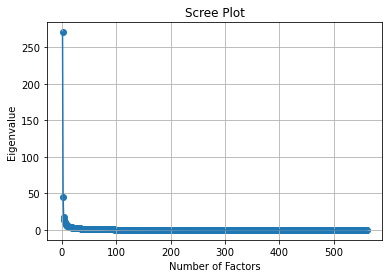

In [13]:
#Analysing and plotting the Scree plot
plt.scatter(range(1,scaled_fa.shape[1]+1),ev)
plt.plot(range(1,scaled_fa.shape[1]+1), ev)
plt.title("Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

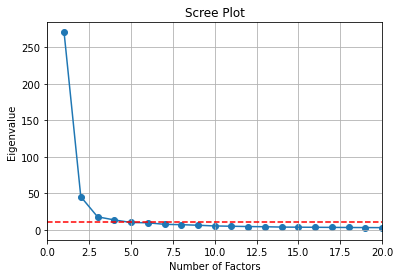

In [28]:
#Zooming in on the Scree plot
plt.scatter(range(1,scaled_fa.shape[1]+1),ev)
plt.plot(range(1,scaled_fa.shape[1]+1), ev)
plt.title("Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.xlim(0, 20)
plt.grid()
plt.axhline(y = 11, color = 'r', linestyle = '--')
plt.show()

From the Scree plot above, we can see that the "elbow" of the graph is around ev = 11 and the number of factors is around 4-5. So factors to the left of the scree plot when y = 12 should be kept and seen as significant while those on the right are deemed as in significant.

In [27]:
#Filter out eigenvalues that are above 11
ev_greater_than1 = ev.copy()
ev_greater_than1 = ev_greater_than1[np.where(ev_greater_than1 > 11)]

#Number of eigenvalue > 11
no_ev_gt1 = len(ev_greater_than1) # = 4

In [29]:
# New FA with Varimax Rotation, using minres
fa1 = FactorAnalyzer(4, rotation="varimax", method='minres', use_smc=True)
fa1.fit(scaled_fa)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [31]:
#Showing the Weights of each variable as a factor to see which features can be considered, sorted in descending order
pd.DataFrame(fa1.loadings_, columns = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], index = [fa_train.columns]).sort_values(by = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], ascending = False)

,Factor 1,Factor 2,Factor 3,Factor 4
tBodyAccJerk-STD-1,0.955349,0.029652,0.083073,0.217267
tBodyAccJerk-Mad-1,0.955236,0.026521,0.080242,0.216464
fBodyAccJerk-Mean-1,0.955213,0.032790,0.088492,0.207901
tBodyAccJerkMag-Mean-1,0.953485,0.042498,0.144872,0.232404
tBodyAccJerkMag-SMA-1,0.953485,0.042498,0.144872,0.232404
...,...,...,...,...
tBodyAcc-Min-2,-0.880259,-0.230537,-0.079229,-0.182246
tBodyGyroJerk-Min-1,-0.885121,-0.042316,-0.090337,-0.207431
tBodyAcc-Min-1,-0.896222,-0.227784,-0.073784,-0.151554
tBodyAccJerk-Min-1,-0.901442,-0.058534,-0.091220,-0.259017


In [39]:
pd.DataFrame(fa1.loadings_, columns = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], index = [fa_train.columns]).sort_values(by = ['Factor 2'], ascending = False)

,Factor 1,Factor 2,Factor 3,Factor 4
tGravityAcc-ARCoeff-10,-0.215451,0.713598,-0.049375,0.095885
tBodyAccMag-ARCoeff-2,0.311729,0.699596,-0.083210,0.157639
tGravityAccMag-ARCoeff-2,0.311729,0.699596,-0.083210,0.157639
tGravityAcc-ARCoeff-12,-0.108358,0.699427,-0.006932,0.136217
tGravityAcc-ARCoeff-6,-0.246969,0.651552,0.004359,0.007547
...,...,...,...,...
tGravityAcc-ARCoeff-11,0.163534,-0.710466,0.028762,-0.116578
tBodyAccMag-ARCoeff-1,-0.295502,-0.736635,0.113920,-0.179186
tGravityAccMag-ARCoeff-1,-0.295502,-0.736635,0.113920,-0.179186
fBodyAcc-MeanFreq-3,0.008985,-0.736815,0.050621,-0.275014


From the loadings, 

Factor 1: tBodyAccJerk-STD-1, tBodyAccJerk-Mad-1, fBodyAccJerk-Mean-1, tBodyAccJerkMag-Mean-1, tBodyAccJerkMag-SMA-1

Factor 2: tGravityAcc-ARCoeff-10

Factor 3: tBodyGyroJerk-Energy-2

Factor 4: tGravityAcc-Min-1

As Factor 1 has several factors which similar loadings.

In [42]:
#Communality of Loading, where values closer to 1 means that that factor explain more of the variance
pd.DataFrame(fa1.get_communalities(), columns = ["Communalities"], index = [fa_train.columns]).sort_values(by = "Communalities", ascending = False)

,Communalities
fBodyAccJerk-SMA-1,0.986456
tBodyAccJerkMag-Mean-1,0.985940
tBodyAccJerkMag-SMA-1,0.985940
tBodyAccJerk-SMA-1,0.985750
fBodyAcc-SMA-1,0.983543
...,...
tBodyAccJerk-Mean-3,0.003149
tBodyGyroJerk-AngleWRTGravity-1,0.003089
tBodyGyroJerk-Mean-2,0.001114
tBodyAccJerk-Mean-1,0.001005


In [45]:
# Showing the Sum of Squared Loading (Variance), Proportional Variance, and Cumulative Variance caused by the 4 factors.
pd.DataFrame(fa1.get_factor_variance(), columns = ["Factor 1", "Factor 2", "Factor 3", "Factor 4"], index = ["Sum Square Loading", "Proportional Variance", "Cumulative Variance"])

,Factor 1,Factor 2,Factor 3,Factor 4
Sum Square Loading,237.556777,52.591384,30.002466,26.131129
Proportional Variance,0.423452,0.093746,0.053480,0.046580
Cumulative Variance,0.423452,0.517198,0.570678,0.617258


From the table above, it can be seen that using the four factors,  can explain around 62% of the variance, which is considered valid but maybe still small (Recommended is > 60% and this is very close to it).

However Factor 1 have several with similar loading, so we may need to consider other methods to reduce the dimensionality of the data!